# Using Exponentially Weighted Moving Averages to navigate trade-offs in systematic trading 

A big part of the job of the indie trader is data analysis. We're always looking in the past data to validate (or more often, invalidate) a hypothesis about what might predict future returns. 

And one could argue that recent data is more useful than past data, since it may reflect the current state of affairs more accurately. Or it might not... market data are inherently noisy, and so there's also value in looking back further into the past and averaging out the effects of that noise. 

For example, say I was interested in the correlation between SPY and TLT. What's more useful to me? The long-term average correlation, or a more up-to-date estimation based on say three months of returns?

It really depends on how "sticky" you think your correlation estimate is - that is, is tomorrow's correlation likely to be the same as today's? But that's another story. The point I really wanted to make was that the long-term estimate will change slowly over time and not react quickly to recent changes, while the short-term estimate will disregard the historical correlation in favour of what's happened more recently. 

And since markets are dominated by noise, those recent data points might be pretty meaningless. Or they might not. You don't really know. In any event, there's certainly a trade-off between stability of our estimates and their responsiveness to new data. 

Let's explore that trade-off. 

We'll start with a plot of TLT/SPY correlations measured over different windows:

The first thing we need to do is get some price data into our session. 

An easy way to do that is to source the functions for getting data from Yahoo Finance that we shared in [this blog post](https://robotwealth.com/yahoo-prices-r-easy/):

In [1]:
library(tidyverse)
library(roll)

# Set chart options
options(repr.plot.width = 14, repr.plot.height=7, warn=-1)
theme_set(theme_bw())
theme_update(text = element_text(size = 20))

# functions for getting prices from Yahoo Finance
source("../data_tools/yahoo_prices.R")

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.2     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.0
✔ ggplot2   3.4.1     ✔ tibble    3.2.1
✔ lubridate 1.9.2     ✔ tidyr     1.3.0
✔ purrr     1.0.1     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors


In [2]:
tickers <- c("TLT", "SPY")
prices <- yahoo_prices(
    tickers,
    from_date = "2003-01-01",
    to_date = "2023-11-02"
  ) %>% 
  arrange(Date, Ticker)
 
head(prices)

,Date,Ticker,Open,High,Low,Close,Adj.Close,Volume
,<date>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>
1,2002-12-31,SPY,87.99,88.43,87.11,88.23,59.45283,34036600
2,2002-12-31,TLT,88.95,89.33,88.32,88.57,44.55145,109400
3,2003-01-02,SPY,88.85,91.30,88.54,91.07,61.36655,44516300
4,2003-01-02,TLT,87.70,87.90,86.21,86.28,43.39953,192100
5,2003-01-03,SPY,90.91,91.38,90.50,91.35,61.55521,32222600
6,2003-01-03,TLT,86.15,86.54,85.83,86.48,43.50018,311200


We can then calculate correlations between the returns of TLT and SPY over different time horizons.  

We'll calculate the average correlation over the entire data set, and rolling correlations on 500- and 90-day windows.

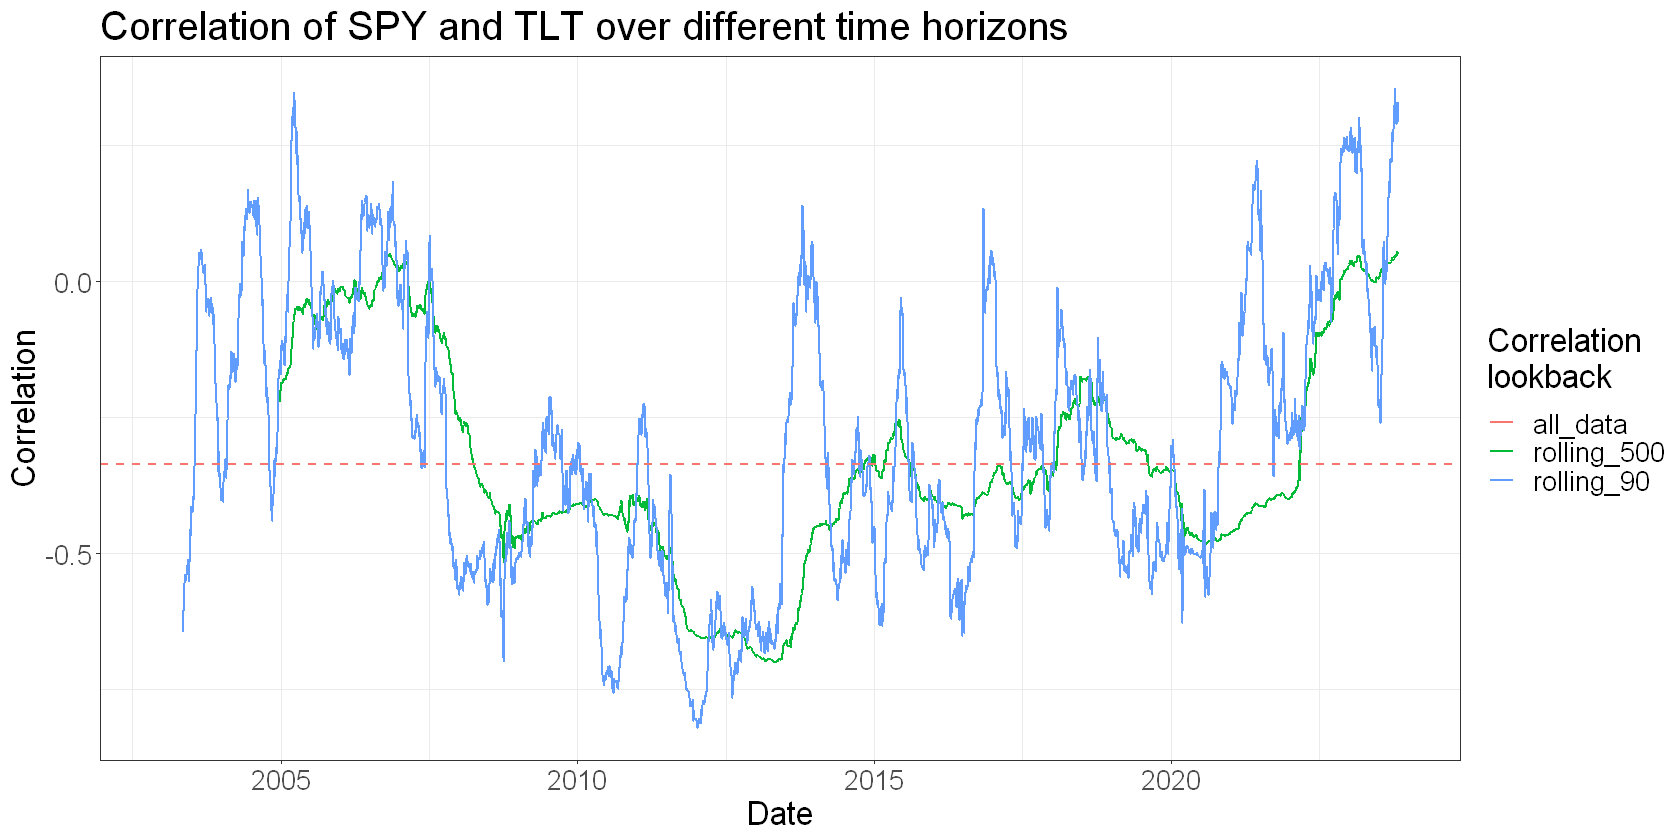

In [3]:
# calculate returns
returns <- prices %>% 
  group_by(Ticker) %>% 
  mutate(
    log_return = log(Adj.Close/dplyr::lag(Adj.Close))
  ) %>% 
  na.omit()

# calculate average correlation over all data
correlation <- returns %>% 
  select(Date, Ticker, log_return) %>% 
  pivot_wider(id_cols=Date, names_from=Ticker, values_from=log_return) %>% 
  summarise(correlation = cor(SPY, TLT)) %>% 
  pull(correlation)

# calculate rolling correlation over different windows
returns %>% 
  select(Date, Ticker, log_return) %>% 
  pivot_wider(id_cols=Date, names_from=Ticker, values_from=log_return) %>% 
  mutate(
    # calculate rolling correlations over short and long lookbacks
    rolling_90 = roll_cor(SPY, TLT, width = 90),
    rolling_500 = roll_cor(SPY, TLT, width = 500)
  ) %>% 
  pivot_longer(c(-Date, -SPY, -TLT), names_to="lookback", values_to="roll_corr") %>% 
  ggplot(aes(x=Date, y=roll_corr, colour=lookback)) +
    geom_line(size=0.8) +
    geom_hline(data=data.frame(corr = correlation, lookback = "all_data"), aes(yintercept=corr, color=lookback), linetype="dashed", size=0.8) +
    # geom_hline(yintercept=correlation, linetype="dashed") +
    labs(
      title="Correlation of SPY and TLT over different time horizons",
      x = "Date",
      y = "Correlation",
      colour = "Correlation\nlookback"
    )

A few things stand out.  

The estimate over the entire data set captures the average correlation. It shows that, on average, SPY and TLT were negatively correlated (~ -0.3).

But when you look at a rolling window of recent data, the correlation of SPY and TLT moves around all over the place. Sometimes they become very negatively correlated (~ -0.6), and sometimes it flips sign and they become very positively correlated. 

You see why this is important... if you looked only at the average correlation, you might think that SPY and TLT make for a nice diversified portfolio. But there are clearly times when they become more correlated and lose that nice diversification effect.

But over what horizon should we measure correlation? 

The shorter window (blue line) is very responsive to recent data - it changes quickly and abruptly. 

The longer window (green line) is more stable. It changes more slowly and gently and within a smaller range. 

Which is better?

Of course it all depends on what you're trying to do. You can imagine that if you had some rule where you flipped out of a position if the correlation crossed some threshold that the shorter window would have you trading hyperactively. But if you used the longer window, you might not react in time to take meaningful action. 

This tension between signal and noise is a fact of life when analysing financial data. But there are things we can do to try to have our cake and eat it too. Namely, to try to include data from the past in our analysis, while giving more credence to recent history. 

One such tool for doing that is the Exponentially Weighted Moving Average (EWMA).

## What is an EWMA?

Exponentially Weighted Moving Average (EWMA) is a type of moving average that gives **more weight** to recent data, making it more responsive to new information. The "exponentially weighted" part means that as you go back in time, the influence of past data on the average decreases exponentially - but never disappears entirely. 

Here's a simple breakdown:

1. **Weighting**: In a simple moving average, every data point in the period (like the last 10 days) gets the same weight. In an EWMA, the most recent data point gets the most weight, and each previous data point gets progressively less weight.  

In the correlation example above, we did the equivalent of a simple moving average where each data point in the window got the same weight. 

2. **The Formula**: The EWMA for a series `Y` at time `t` is calculated using the following formula:
   
   $EWMA_t = (1 - \lambda) \times Y_t + \lambda \times EWMA_{t-1}$

   Here:
   - `EWMA_t` is the exponentially weighted moving average at time `t`.
   - `Y_t` is the actual value at time `t`.
   - `λ` (lambda) is the smoothing factor, between 0 and 1. A higher lambda places less weight on recent data.
   - `EWMA_{t-1}` is the EWMA value from the previous period.

3. **Lambda**: The value of λ determines how quickly the weight of previous observations decreases. A small λ makes the average decay quickly, so it's more sensitive to recent changes. A large λ makes it decay slowly, so it's more stable and less sensitive to recent changes.

Note that the definition of λ I've used here is in line with [Risk Metrics](https://www.msci.com/documents/10199/5915b101-4206-4ba0-aee2-3449d5c7e95a), but might be opposite to lambda's usage in other applications (ie in other implementations a higher λ makes the series decay more quickly). 

## Implementing the EWMA in R

To implement the EWMA in R, we need to be aware of a few of its characteristics. Firstly, each value depends on the previous value - that's the $EWMA_{t-1}$ term. That means that we can't vectorise the calculation of the EWMA, so unfortunately one of R's very efficient computation methods is unavailable to us. 

Secondly, early values of the EWMA will be very volatile - since we have little history in our series, the EWMA will be very dependent on a small number of values. It will take some number of observations for the EWMA to "settle down" and start behaving sensibly. 

For that reason, we include a `warmup` parameter that defines how many observations to discard from the start of the series. In this approach, we replace those warmup values with `NA`. 

In [6]:
ewma <- function(data, lambda, warmup=20) {
  ewma <- numeric(length(data))
  ewma[1] <- data[1]  # initialize with the first data point

  for (i in 2:length(data)) {
    ewma[i] <- (1 - lambda) * data[i] + (lambda) * ewma[i-1]
  }
  
  # drop the warmup period and replace with NA
  return(c(rep(NA, warmup), ewma[(warmup+1):length(ewma)]))
}

Let's take a look at this function in action. We'll plot EWMAs and SMAs of the price of SPY and TLT:

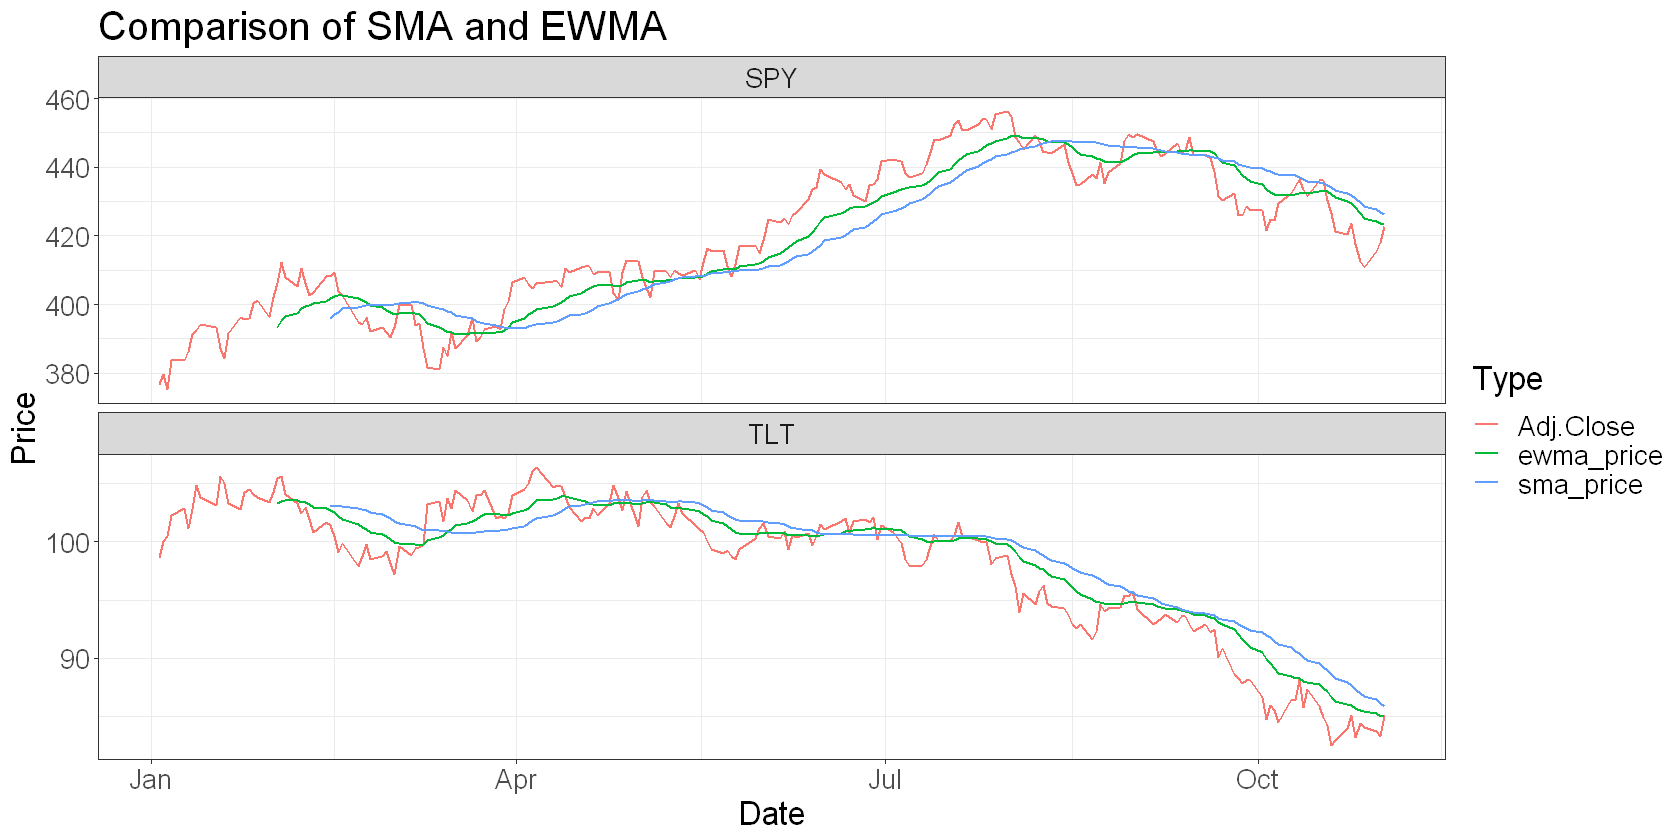

In [7]:
prices %>% 
  filter(Date >= "2023-01-01") %>% 
  group_by(Ticker) %>% 
  mutate(
    sma_price = roll_mean(Adj.Close, width=30),
    ewma_price = ewma(Adj.Close, lambda=0.9, warmup=20)
  ) %>% 
  pivot_longer(c(Adj.Close, sma_price, ewma_price), names_to="Type", values_to="Price") %>% 
  ggplot(aes(x=Date, y=Price, colour=Type)) +
  geom_line(size=0.8) +
  facet_wrap(~Ticker, ncol=1, scales="free_y") +
  labs(
    title = "Comparison of SMA and EWMA"
  )

You can see that the EWMA (green line) is more responsive than the SMA (blue). I think it does a better job of smoothing out the noise while being true to the underlying "trend" in the data. 

Next, I want to make this `ewma` function a little more performant. I mentioned that since the next value of the EWMA depends on the previous one, we can't vectorise this and must use a `for` loop. But loops are not efficient in R. This isn't a big deal when we're using daily prices as we are here, but if we wanted to use higher frequency data, or we had many EWMAs to calculate, we might want to speed things up a bit. For that, we can port our function to C++ using `Rcpp`.

## Implemetning the EWMA in `Rcpp`

Implementing the EWMA in Rcpp is pretty simple. Our R function is fairly trivial, so we can translate it to C++ fairly easily.

To compile and make it available in our session, we can use the `Rcpp::sourceCpp` function and pass it the C++ function as one long string:

In [4]:
library(Rcpp)

sourceCpp(
  code = 
    "
     #include <Rcpp.h>
     // [[Rcpp::export]]
     Rcpp::NumericVector ewma_rcpp(Rcpp::NumericVector x, double lambda, int warmup=20){
       int n = x.length();
       Rcpp::NumericVector ewma(n);
       ewma[0] = x[0];
       if (n > 1) {
         for (int i = 1; i < n; i++) {
           ewma[i] = (1 - lambda) * x[i] + lambda * ewma[i-1];
         }
       }
       for (int i = 0; i < warmup; i++) {
        ewma[i] = NA_REAL;
       }
       return ewma;
     }
    "
)

Let's see if it looks the same as the R implementation:

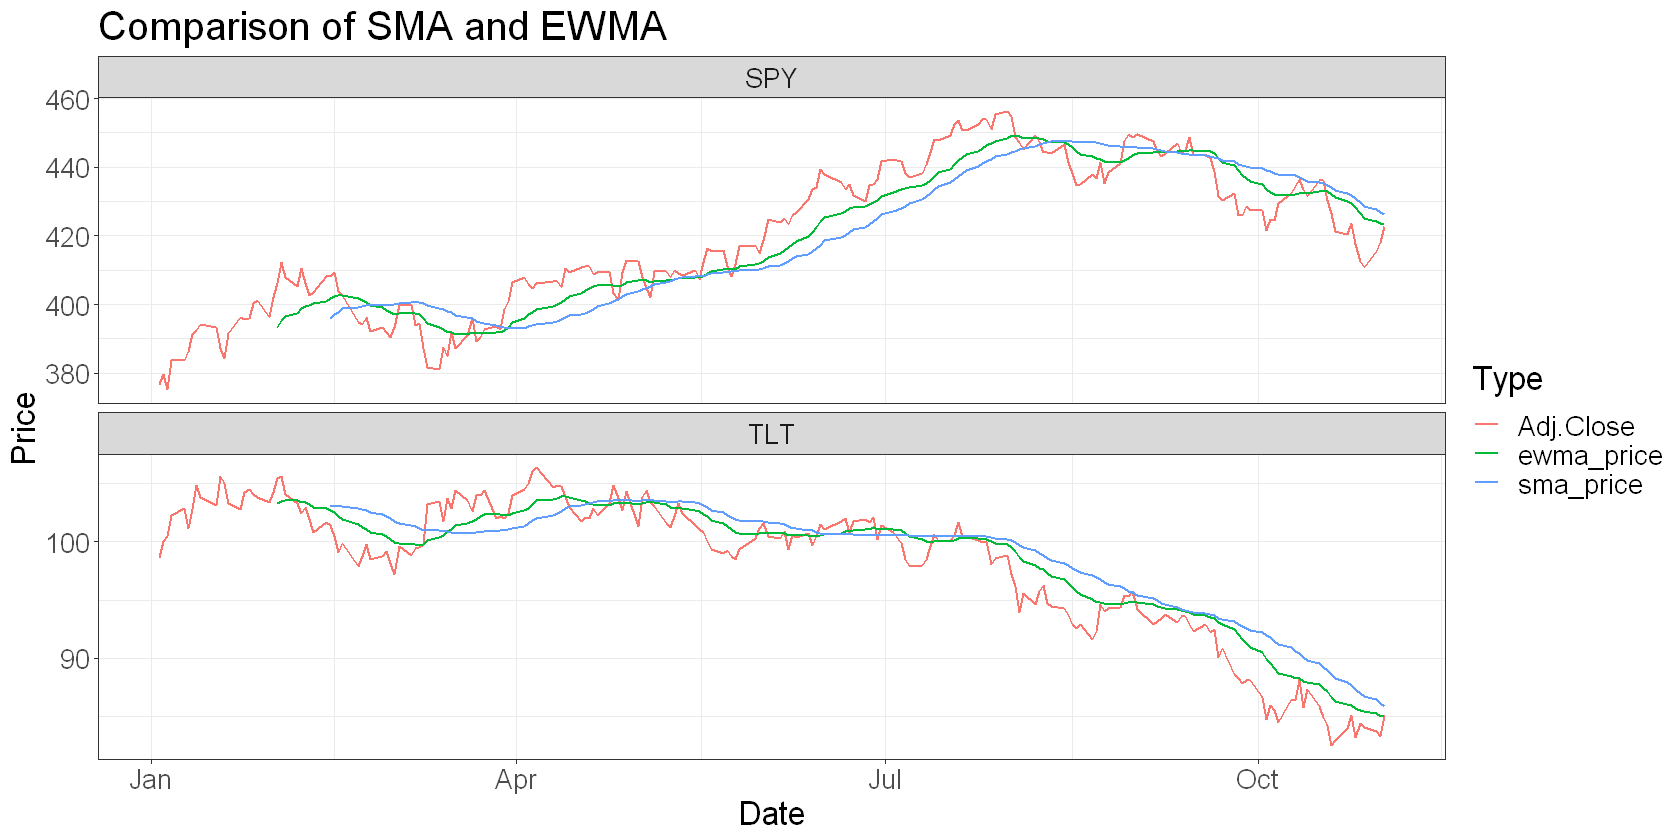

In [9]:
prices %>% 
  filter(Date >= "2023-01-01") %>% 
  group_by(Ticker) %>% 
  mutate(
    sma_price = roll_mean(Adj.Close, width=30),
    ewma_price = ewma_rcpp(Adj.Close, lambda=0.9, warmup=20)
  ) %>% 
  pivot_longer(c(Adj.Close, sma_price, ewma_price), names_to="Type", values_to="Price") %>% 
  ggplot(aes(x=Date, y=Price, colour=Type)) +
  geom_line(size=0.8) +
  facet_wrap(~Ticker, ncol=1, scales="free_y") +
  labs(
    title = "Comparison of SMA and EWMA"
  )

Looks good! Let's see what sort of speedup we got:

[1] 5246
Unit: microseconds
                      expr   min     lq    mean median     uq   max neval
      ewma(test_data, 0.9) 447.1 484.00 523.850 497.80 539.35 796.8   100
 ewma_rcpp(test_data, 0.9)  16.6  26.65  29.534  28.25  30.85  69.6   100


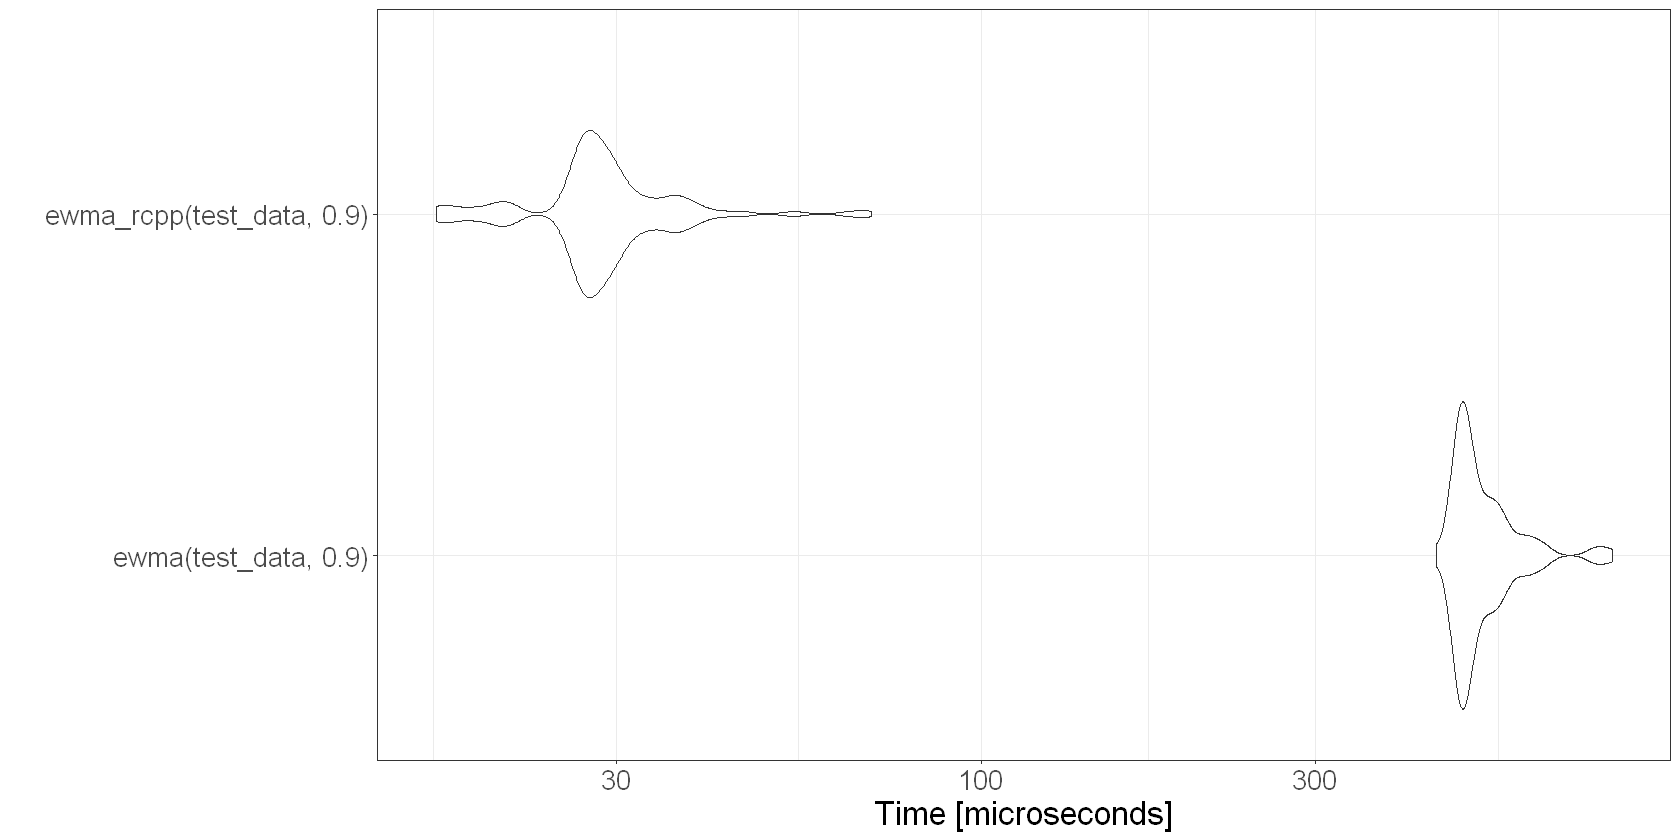

In [145]:
library(microbenchmark)

test_data <- prices %>% 
 filter(Ticker == "SPY") %>% 
 pull(Adj.Close)

print(length(test_data))

benchmark_results <- microbenchmark(
  ewma(test_data, 0.9),
  ewma_rcpp(test_data, 0.9),
  times = 100L  
)

print(benchmark_results)
autoplot(benchmark_results)

Our original base R function wasn't that slow... it processed a series of ~5,200 data points in about 525 microseconds on average. So that's totally fine for casual usage and won't slow you down at all. 

But if you're calculating a lot of these things, then you'll benefit from the ~18x speed-up we get with our Rcpp code, where the average was about 30 microseconds. 

## Exponentially weighted correlation

Let's revisit our original example of estimating the correlation of SPY and TLT. 

We saw that there's a tension between reacting fast and reacting smoothly when we use normal moving windows to estimate correlations. Let's see if we can use an EWMA to navigate this tension. 

First, we need a function for calculating an exponentially weighted correlation. I'll use the approach in [Risk Metrics](https://www.msci.com/documents/10199/5915b101-4206-4ba0-aee2-3449d5c7e95a) (Eq. 5.8, page 83). 

In this approach, we:
- Estimate an EWMA covariance 
- Estimate asset-wise EWMA variances and convert to standard deviations
- The EWMA correlation is then just the covariance divided by the product of the standard deviations 

In this approach, we need an initialisation window over which we get our initial covariance and variance estimates. We then update those in an exponentially weighted fashion, and use them to calculate the exponentially weighted correlation. 

In [10]:
# EWMA correlation estimate
# Approach is as follows:
  # Calculate ewma covariance 
  # Calculate ewma asset-wise variance estimates
  # Correlation estimate is cov/(sqrt(var1)*sqrt(var2))
ewma_cor <- function(x, y, lambda, initialisation_wdw = 100) {  
  # create initialisation window and estimation window
  init_x = x[1:initialisation_wdw]
  init_y = y[1:initialisation_wdw]

  # number of observations
  # TODO: should check that x and y are the same length
  num_obs <- length(x)
  
  # initial covariance, variance, and mean return estimates
  old_cov <- cov(init_x, init_y)
  old_var_x <- var(init_x)
  old_var_y <- var(init_y)
  old_x <- mean(init_x)
  old_y <- mean(init_y)
  
  # preallocate output vector
  ewma_cor <- vector(mode = "numeric", length = num_obs)

  # pad with NA for initialisation window
  ewma_cor[1:initialisation_wdw] <- NA
  
  # correlation estimate from ewma covariance and variances
  # use superfluous temporary variables to make the sequence of steps explicit
  for(i in c((initialisation_wdw+1):num_obs)) { 
    # cov estimate
    this_cov <- lambda*old_cov + (1 - lambda)*(old_x * old_y)
    # var estimates
    this_var_x <- lambda * old_var_x + (1 - lambda) * old_x^2
    this_var_y <- lambda * old_var_y + (1 - lambda) * old_y^2
    # correlation estimate
    ewma_cor[i] <- this_cov / (sqrt(this_var_x) * sqrt(this_var_y))
    
    # update values
    old_cov <- this_cov
    old_var_x <- this_var_x
    old_var_y <- this_var_y
    old_x <- x[i]
    old_y <- y[i]
  }
  ewma_cor
}

Let's test it out:

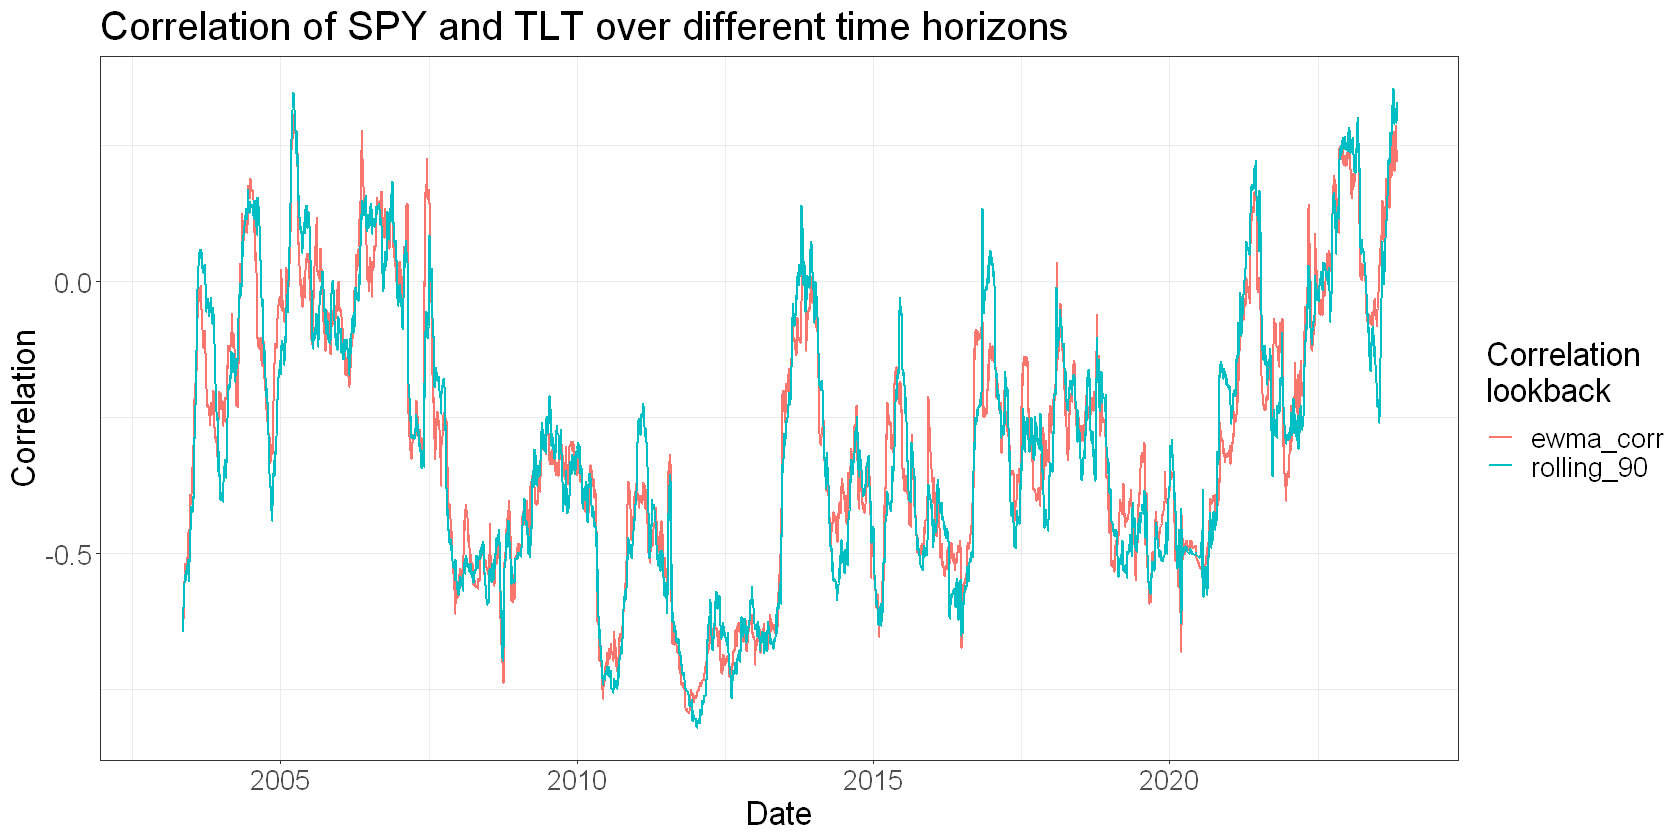

In [11]:
# calculate rolling correlation and an exponentially weighted correlation
returns %>% 
  select(Date, Ticker, log_return) %>% 
  pivot_wider(id_cols=Date, names_from=Ticker, values_from=log_return) %>% 
  mutate(
    # calculate rolling correlations over short and long lookbacks
    rolling_90 = roll_cor(SPY, TLT, width = 90),
    ewma_corr = ewma_cor(SPY, TLT, lambda = 0.98, initialisation_wdw = 90)
  ) %>% 
  pivot_longer(c(-Date, -SPY, -TLT), names_to="corr_type", values_to="correlation") %>% 
  ggplot(aes(x=Date, y=correlation, colour=corr_type)) +
    geom_line(size=0.8) +
    labs(
      title="Correlation of SPY and TLT over different time horizons",
      x = "Date",
      y = "Correlation",
      colour = "Correlation\nlookback"
    )

You can see that the EWMA correlation estimate is both responsive and arguably less jittery than the 90-day moving window correlation estimate.  

Let's zoom in to see this better:

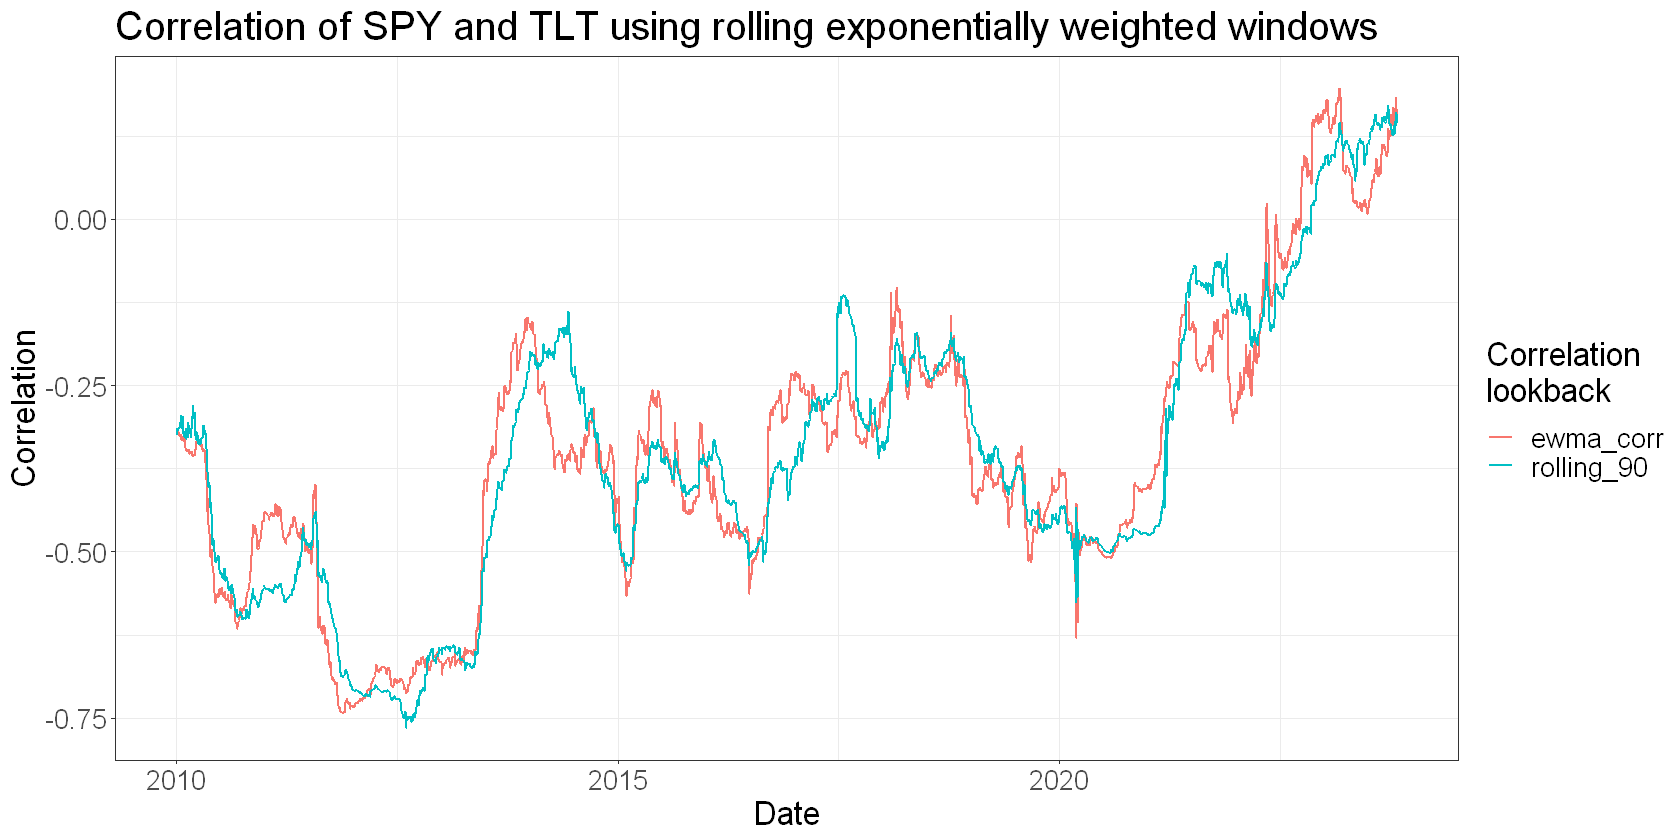

In [12]:
# calculate rolling correlation and an exponentially weighted correlation
returns %>% 
  filter(Date >= "2009-01-01") %>% 
  select(Date, Ticker, log_return) %>% 
  pivot_wider(id_cols=Date, names_from=Ticker, values_from=log_return) %>% 
  mutate(
    # calculate rolling correlations over short and long lookbacks
    rolling_90 = roll_cor(SPY, TLT, width = 252),
    ewma_corr = ewma_cor(SPY, TLT, lambda = 0.99, initialisation_wdw = 252)
  ) %>% 
  pivot_longer(c(-Date, -SPY, -TLT), names_to="corr_type", values_to="correlation") %>% 
  na.omit() %>% 
  ggplot(aes(x=Date, y=correlation, colour=corr_type)) +
    geom_line(size=.8) +
    labs(
      title="Correlation of SPY and TLT using rolling exponentially weighted windows",
      x = "Date",
      y = "Correlation",
      colour = "Correlation\nlookback"
    )

In this approach, the decay effect from lamda is applied separately to both the covariance and the variances, not the correlation estimate itself. This implies an interesting possibility of using different decay rates on the variances and covariances, if you think that maybe they change at different rates. This might find application in position sizing, where maybe you want to respond to changes in volatility faster than changes in the co-movement of assets. 

Here's an example of how you might implement that and what a more responsive variance estimate would look like:

In [13]:
# EWMA correlation estimate
# uses different lambdas for covariance and variance estimates
ewma_cor_2 <- function(x, y, cov_lambda, var_lambda, initialisation_wdw = 100) {  
  # create initialisation window and estimation window
  init_x = x[1:initialisation_wdw]
  init_y = y[1:initialisation_wdw]

  # number of observations
  # TODO: should check that x and y are the same length
  num_obs <- length(x)
  
  # initial covariance, variance, and mean return estimates
  old_cov <- cov(init_x, init_y)
  old_var_x <- var(init_x)
  old_var_y <- var(init_y)
  old_x <- mean(init_x)
  old_y <- mean(init_y)
  
  # preallocate output vector
  ewma_cor <- vector(mode = "numeric", length = num_obs)

  # pad with NA for initialisation window
  ewma_cor[1:initialisation_wdw] <- NA
  
  # correlation estimate from ewma covariance and variances
  # use superfluous temporary variables to make the sequence of steps explicit
  for(i in c((initialisation_wdw+1):num_obs)) { 
    # cov estimate
    this_cov <- cov_lambda*old_cov + (1 - cov_lambda)*(old_x * old_y)
    # var estimates
    this_var_x <- var_lambda * old_var_x + (1 - var_lambda) * old_x^2
    this_var_y <- var_lambda * old_var_y + (1 - var_lambda) * old_y^2
    # correlation estimate
    ewma_cor[i] <- this_cov / (sqrt(this_var_x) * sqrt(this_var_y))
    
    # update values
    old_cov <- this_cov
    old_var_x <- this_var_x
    old_var_y <- this_var_y
    old_x <- x[i]
    old_y <- y[i]
  }
  ewma_cor
}

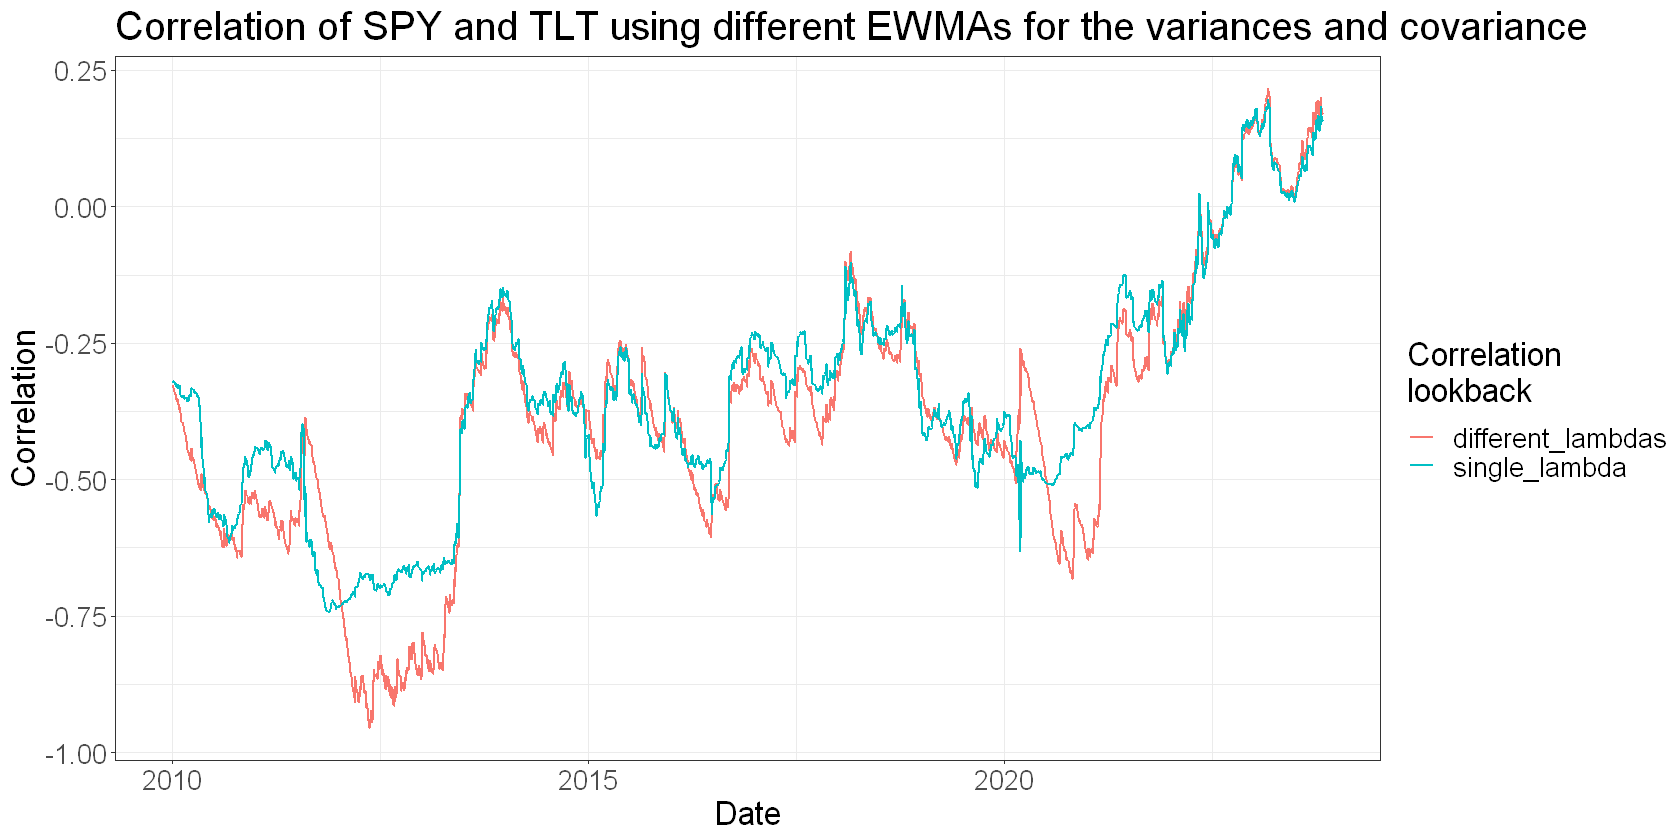

In [14]:
# calculate rolling correlation and an exponentially weighted correlation
returns %>% 
  filter(Date >= "2009-01-01") %>% 
  select(Date, Ticker, log_return) %>% 
  pivot_wider(id_cols=Date, names_from=Ticker, values_from=log_return) %>% 
  mutate(
    # calculate rolling correlations over short and long lookbacks
    single_lambda = ewma_cor(SPY, TLT, lambda = 0.99, initialisation_wdw = 252),
    different_lambdas = ewma_cor_2(SPY, TLT, var_lambda = 0.98, cov_lambda = 0.99, initialisation_wdw = 252)
  ) %>% 
  pivot_longer(c(-Date, -SPY, -TLT), names_to="corr_type", values_to="correlation") %>% 
  na.omit() %>% 
  ggplot(aes(x=Date, y=correlation, colour=corr_type)) +
    geom_line(size=0.8) +
    labs(
      title="Correlation of SPY and TLT using different EWMAs for the variances and covariance",
      x = "Date",
      y = "Correlation",
      colour = "Correlation\nlookback"
    )

## Summary

Exponentially weighted estimates can help traders navigate the trade-offs around stability and responsiveness of estimates of quantities such as correlation, covariance, and variance. 

In this article, we implemented functions for: 
- Calculating an EWMA of a vector 
- Doing it faster using Rcpp
- Estimating an exponentially weighted correlation between two assets 
- Doing it using different decay factors for the variance and covariance estimates. 

Next time, I’ll show you how I estimate an exponentially weighted covariance matrix for a portfolio of assets. This is particularly useful if you need a stable yet responsive estimate of risk, for example if you were doing medium frequency portfolio optimisation.